https://www.kaggle.com/competitions/reconocimiento-de-expresiones-faciales

In [6]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Rutas de los archivos CSV
train_csv_path = 'train_set.csv'
test_csv_path = 'test_set.csv'
sample_submission_path = 'sample_submision.csv'

# Leer los archivos CSV
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sample_submission_df = pd.read_csv(sample_submission_path)

In [8]:
train_df.head()

,id_img,path,label
0,0,../data/images/train/angry\0.jpg,angry
1,1,../data/images/train/angry\1.jpg,angry
2,10,../data/images/train/angry\10.jpg,angry
3,10002,../data/images/train/angry\10002.jpg,angry
4,10016,../data/images/train/angry\10016.jpg,angry


In [9]:
def replace_backslash(path):
    return path.replace('\\', '/')

# Aplicar la función a la columna 'path'
train_df['path'] = train_df['path'].apply(replace_backslash)

In [10]:
train_df.head()

,id_img,path,label
0,0,../data/images/train/angry/0.jpg,angry
1,1,../data/images/train/angry/1.jpg,angry
2,10,../data/images/train/angry/10.jpg,angry
3,10002,../data/images/train/angry/10002.jpg,angry
4,10016,../data/images/train/angry/10016.jpg,angry


In [11]:
# Definir rutas
ROOT_PATH = './data/images/'
TRAIN_PATH = ROOT_PATH + "train/"
TEST_PATH = ROOT_PATH + "test/"

In [12]:
TRAIN_PATH

'./data/images/train/'

In [13]:
# Visualizar los primeros registros de los DataFrames
print(train_df.head())
print("-----------")
print(test_df.head())
print("-----------")
print(sample_submission_df.head())

   id_img                                  path  label
0       0      ../data/images/train/angry/0.jpg  angry
1       1      ../data/images/train/angry/1.jpg  angry
2      10     ../data/images/train/angry/10.jpg  angry
3   10002  ../data/images/train/angry/10002.jpg  angry
4   10016  ../data/images/train/angry/10016.jpg  angry
-----------
   id_img
0   10052
1   10065
2   10079
3   10095
4   10121
-----------
   id_img     label
0   10052  surprise
1   10065  surprise
2   10079  surprise
3   10095  surprise
4   10121  surprise


In [14]:
# Función para cargar y preprocesar las imágenes de entrenamiento
def read_train_data(dataframe, reshape_dim=(48, 48)):
    X = []
    y = []
    for index, row in dataframe.iterrows():
        img_path = os.path.join(ROOT_PATH, row['path'].replace('../data/images/', ''))
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Leer en escala de grises
        if image is not None:
            image = cv2.resize(image, reshape_dim)  # Redimensionar a 32x32
            X.append(image)
            y.append(row['label'])
    
    X = np.array(X)  # Agregar canal de color
    y = np.array(y)
    return X, y

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [15]:
def read_test_data(dataframe, reshape_dim =(48, 48)):
    X = []
    for index, row in dataframe.iterrows():
        img_path = os.path.join(TEST_PATH, f"{row['id_img']}.jpg")
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Leer en escala de grises
        if image is not None:
            image = cv2.resize(image, reshape_dim)  # Redimensionar a 32x32
            X.append(image)
    
    X = np.array(X)  # Agregar canal de color
    return X

In [16]:
X_train, y_train = read_train_data(train_df)

In [17]:
X_test = read_test_data(test_df)

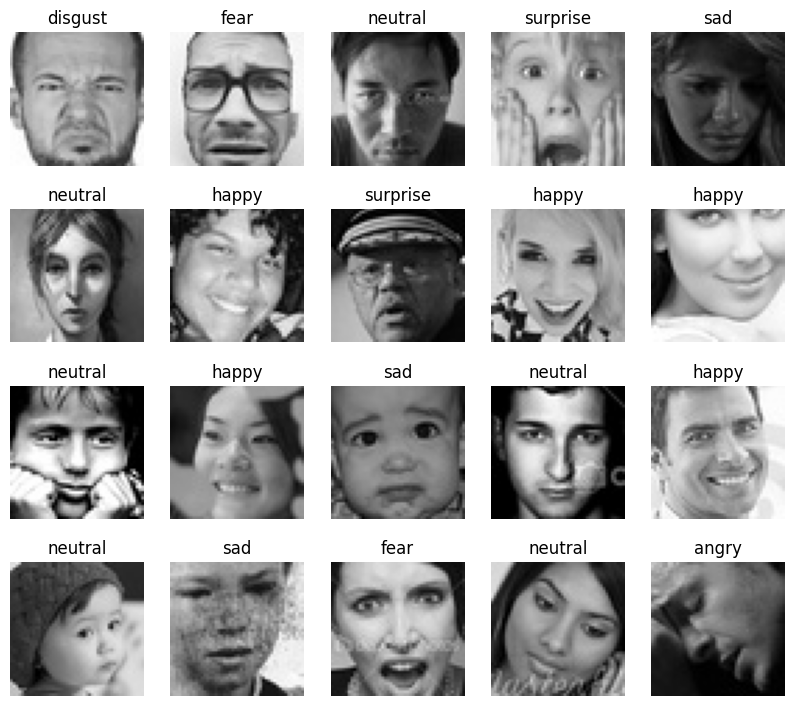

In [18]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [19]:
X_train = X_train/255
X_test = X_test/255

In [20]:
X_train.size

199210752

In [30]:

# Cargamos el modelo pre-entrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False


# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)
    
    # Tantas unidades como el flatten de la salida de Inception -> 5625 features
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(7, activation='softmax')(x)
    
    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc']) # sparse -> y es un array de escalares pero hay varias categorias, y un array de vectores
    return model
# Observamos la arquitectura del modelo
model= prepare_model()



In [31]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 901
Batch_size: 64, num_steps_per_epoch: 450
Batch_size: 96, num_steps_per_epoch: 300
Batch_size: 128, num_steps_per_epoch: 225


In [32]:
targets = pd.Series(y_train)

In [33]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [34]:
y_train_num = np.array([mapa[y] for y in y_train])

In [35]:
batch_size = 128
earlyS = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)

In [36]:
from sklearn.utils import shuffle
X_train_s,y_train_s = shuffle(X_train, y_train_num)

In [37]:
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])

Epoch 1/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 170s 936ms/step - acc: 0.3263 - loss: 1.7086 - val_acc: 0.3752 - val_loss: 1.6029
Epoch 2/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 159s 880ms/step - acc: 0.3887 - loss: 1.5629 - val_acc: 0.4113 - val_loss: 1.5231
Epoch 3/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 144s 798ms/step - acc: 0.4234 - loss: 1.4968 - val_acc: 0.4031 - val_loss: 1.5264
Epoch 4/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 138s 761ms/step - acc: 0.4439 - loss: 1.4637 - val_acc: 0.4193 - val_loss: 1.5178
Epoch 5/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 150s 828ms/step - acc: 0.4505 - loss: 1.4283 - val_acc: 0.4083 - val_loss: 1.5368
Epoch 6/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 141s 781ms/step - acc: 0.4665 - loss: 1.4001 - val_acc: 0.4252 - val_loss: 1.4967
Epoch 7/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 134s 740ms/step - acc: 0.4795 - loss: 1.3703 - val_acc: 0.4349 - val_loss: 1.4899
Epoch 8/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 131s 722ms/step - acc: 0.4896 - loss: 1.3356 - val_acc: 0.4290 - val_loss: 1.4963
Epoch 9/40
181/181 ━━━━━

In [44]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

221/221 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step


In [45]:
mapa_invertido = {v: k for k, v in mapa.items()}
print("Mapa invertido:", mapa_invertido)

Mapa invertido: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [46]:
predicciones = np.array([mapa_invertido[y] for y in y_pred])

In [47]:
submission = pd.DataFrame({
    'id_img': test_df['id_img'],
    'label': predicciones
})

In [48]:
submission

,id_img,label
0,10052,happy
1,10065,neutral
2,10079,angry
3,10095,angry
4,10121,angry
...,...,...
7061,9806,surprise
7062,9830,happy
7063,9853,surprise
7064,9878,neutral


In [49]:
submission.to_csv('submission_2.csv', index=False)